In [1]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 1
from stack_nlp import *
from jupyter_mplsettings import *
matplotlib.rc('font', **font)

In [2]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [3]:
cfg = local_import("./laptop.py")

In [4]:
PrepareData(cfg)

Shape of question df (1696819, 21)
Shape of answer df (2028240, 21)
Loading word dictionary...
Shape of dictionary (3048821, 4)
Warning! Dropping some words from word list, please verify!
Dropping 1211
Shape of merged df (1000000, 33)
Selecting only questions with at least 5 meaningful words.
This removes 8582 questions.
Removing bad values with missing feature information.
This affects 19 questions.
Calculating normalized columns. They are available under usual column name + _norm.


In [5]:
data = cfg.data

In [6]:
data.keys()

['meta', 'dict', 'features', 'answers']

In [7]:
qs = data["meta"];

In [8]:
qs.head()
print qs.shape

(991399, 52)


In [9]:
print np.sum(~qs.dt_answer.isnull())
print np.sum(~qs.dt_accanswer.isnull())

706703
386998


In [10]:
qs.columns
cols_desc

{'AnswerCount': 'Number of replies',
 'BodyNCodes': 'Number of code tags',
 'BodyNQMarks': 'Number of question marks',
 'BodySize': 'Length of post text',
 'Score': 'Question score',
 'nwords': 'Number of meaningful words',
 'ordermean': 'Word prevalence (average)',
 'orderstd': 'Word prevalence (std)',
 'ordersum': 'Word prevalence (sum)',
 'prob_bern': 'Joined bernoulli probability of words',
 'ratio': 'Ratio of number of verbs to nouns',
 'titlelen': 'Length of title'}

In [11]:
n_timecat = 3
timecat_bins = np.linspace(-0.5, n_timecat + 0.5, n_timecat + 2)

qs["dayhour"] = qs.CreationDate.dt.hour
qs["weekday"] = qs.CreationDate.dt.dayofweek
qs["day"] = qs.CreationDate.dt.dayofyear
# training and testing samples
qs = shuffle(qs)
print "Length of the whole shuffled question df:", len(qs)
# limiting to questions with accepted answer for training

tmask = np.isfinite(qs.dt_accanswer_hour)
time_categories = mquantiles(qs.loc[tmask].dt_accanswer_hour, prob=np.linspace(0, 1, n_timecat + 1))
print "Bins for time categories", time_categories
qs["timecat"] = 0
qs.loc[tmask, "timecat"] = np.digitize(qs.loc[tmask].dt_accanswer_hour, time_categories) - 1
qs.loc[~tmask, "timecat"] = n_timecat

qssel = qs[tmask]
qssel = qssel.append(qs[~tmask].iloc[:int(len(qssel) * 1. / (len(time_categories) - 1))])
qssel = shuffle(qssel)

# train = 100000
train = 50000
qstrain = qssel.iloc[:train]
qstest = qssel.iloc[-train:]
print "Length of the training set:", len(qstrain)
print "Length of the testing set:", len(qstest)

# label = "dt_accanswer_hour"
label = "timecat"

# sample with no answers, aka the ultimate testing sample
qsnone = qs[qs.AnswerCount == 0]
print "Number of questions without answer:", len(qsnone)

Length of the whole shuffled question df: 991399
Bins for time categories [  0.00000000e+00   2.84184000e-01   2.24010240e+00   5.47461192e+03]


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Length of the training set: 50000
Length of the testing set: 50000
Number of questions without answer: 284672


In [12]:
time_categories

array([  0.00000000e+00,   2.84184000e-01,   2.24010240e+00,
         5.47461192e+03])

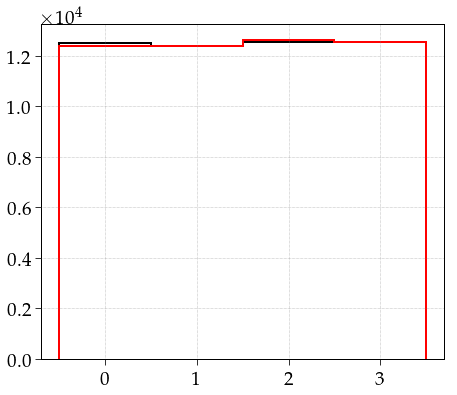

In [13]:
plt.figure(figsize=(8, 6))
qstrain.timecat.hist(color="k", lw=2, histtype="step", bins=timecat_bins)
qstest.timecat.hist(color="red", lw=2, histtype="step", bins=timecat_bins)

In [14]:
vocab_size = 2000
train_docs = qstrain.hot_indices.str.split(";").apply(lambda x: [int(xi) for xi in x[:-1] if int(xi) < vocab_size])
test_docs = qstest.hot_indices.str.split(";").apply(lambda x: [int(xi) for xi in x[:-1] if int(xi) < vocab_size])

In [15]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, Conv1D, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D

Using TensorFlow backend.


In [16]:
to_categorical(qstrain[label]).shape

(50000, 4)

In [17]:
# pad documents to a max length of 4 words
max_length = 200
train_padded_docs = pad_sequences(train_docs, maxlen=max_length, padding='post')
test_padded_docs = pad_sequences(test_docs, maxlen=max_length, padding='post')

In [18]:
print train_padded_docs

[[ 149 1991 1136 ...,    0    0    0]
 [1172 1463  723 ...,    0    0    0]
 [ 235   36 1368 ...,    0    0    0]
 ..., 
 [   2 1984   77 ...,    0    0    0]
 [ 150  347    1 ...,    0    0    0]
 [ 816  347    2 ...,    0    0    0]]


In [ ]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_length))
# model.add(Flatten())

model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(4, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
# fit the model
model.fit(train_padded_docs, to_categorical(qstrain[label]), epochs=100, batch_size=2000,
          validation_data=(test_padded_docs, to_categorical(qstest[label])))
# evaluate the model
loss, accuracy = model.evaluate(test_padded_docs, to_categorical(qstest[label]))

print('Accuracy: %f' % (accuracy * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          256000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 355,332
Trainable params: 355,332
Non-trainable params: 0
_________________________________________________________________
None
Train on 50000 samples, validate on 50000 samples
Epoch 1/100
 6000/50000 [==>...........................] - ETA: 2:59 - loss: 1.3858 - acc: 0.2640

In [64]:
batch_size = 200
filters = 250
kernel_size = 3
hidden_dims = 250

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(vocab_size, 100, input_length=max_length))

model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
# model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(7, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(train_padded_docs, to_categorical(qstrain[label]),
          epochs=100, batch_size=batch_size,
          validation_data=(test_padded_docs, to_categorical(qstest[label])))

Build model...
Train on 20000 samples, validate on 20000 samples
Epoch 1/100
20000/20000 [==============================] - 104s 5ms/step - loss: 1.9359 - acc: 0.1666 - val_loss: 1.9007 - val_acc: 0.1931
Epoch 2/100
20000/20000 [==============================] - 114s 6ms/step - loss: 1.8773 - acc: 0.2145 - val_loss: 1.8809 - val_acc: 0.2146
Epoch 3/100
20000/20000 [==============================] - 124s 6ms/step - loss: 1.8357 - acc: 0.2381 - val_loss: 1.8827 - val_acc: 0.2171
Epoch 4/100
20000/20000 [==============================] - 125s 6ms/step - loss: 1.7978 - acc: 0.2532 - val_loss: 1.8919 - val_acc: 0.2163
Epoch 5/100
20000/20000 [==============================] - 129s 6ms/step - loss: 1.7342 - acc: 0.2883 - val_loss: 1.9289 - val_acc: 0.2052
Epoch 6/100
20000/20000 [==============================] - 131s 7ms/step - loss: 1.6365 - acc: 0.3303 - val_loss: 2.0293 - val_acc: 0.1957
Epoch 7/100
 7400/20000 [==========>...................] - ETA: 1:11 - loss: 1.4842 - acc: 0.4032

KeyboardInterrupt: 